In [17]:
#%pip install -r requirements.txt

In [18]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Environment and Configuration
from dotenv import load_dotenv

# LLM and Vector Store Libraries
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import CSVLoader, TextLoader
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema import StrOutputParser, Document 
from langchain.text_splitter import CharacterTextSplitter

# Load environment variables
load_dotenv()

# Configuration and Global Setup
# Metric file paths
METRIC_FILES = {
    'amf': 'data/amf_metrics.csv',
    'smf': 'data/smf_metrics.csv',
    'upf': 'data/upf_metrics.csv'
}
ALERTS_FILE = 'data/alerts.json'

# Initialize LLM
def get_llm(model='gpt-4'):
    """Initialize Language Model"""
    openai_api_key = os.getenv('OPENAI_API_KEY')
    if not openai_api_key:
        openai_api_key = input("Please enter your OpenAI API key: ")
        os.environ["OPENAI_API_KEY"] = openai_api_key
    return ChatOpenAI(temperature=0, model_name=model)

# Initialize global LLM
llm = get_llm()

In [19]:
# Data Loading and Preprocessing
def load_metrics(filenames):
    """
    Load and preprocess telecom metrics
    
    Args:
        filenames (dict): Dictionary of metric file paths
    
    Returns:
        dict: Processed metrics datasets
    """
    datasets = {}
    for name, file in filenames.items():
        df = pd.read_csv(file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.sort_values('timestamp', inplace=True)
        
        # Add description column for embedding
        df['description'] = df.apply(
            lambda row: f"{row['timestamp']} - " +
                        " | ".join([f"{col}: {row[col]}" 
                                    for col in df.columns 
                                    if col not in ['timestamp', 'description']]),
            axis=1
        )
        
        datasets[name] = df
    return datasets

# Anomaly Detection
def detect_anomalies(datasets, threshold=3):
    """
    Detect anomalies using z-score method
    
    Args:
        datasets (dict): Metrics datasets
        threshold (float): Z-score threshold
    
    Returns:
        dict: Anomaly flags for each dataset
    """
    anomalies = {}
    for name, df in datasets.items():
        numeric_data = df.drop(columns=['timestamp', 'description'])
        anomaly_flags = (np.abs((numeric_data - numeric_data.mean()) / numeric_data.std()) > threshold)
        anomalies[name] = pd.concat([df[['timestamp']], anomaly_flags], axis=1)
    return anomalies

# Anomaly Correlation
def correlate_anomalies(anomalies):
    """
    Correlate anomalies across network functions
    
    Args:
        anomalies (dict): Anomaly DataFrames
    
    Returns:
        pd.DataFrame: Correlated anomalies
    """
    combined = anomalies['amf']
    for name, df in anomalies.items():
        if name != 'amf':
            combined = pd.merge(combined, df, on='timestamp', suffixes=(f'_{name}_amf', f'_{name}'))
    combined['combined_anomaly'] = combined.drop(columns=['timestamp']).any(axis=1)
    return combined[combined['combined_anomaly']]

# Visualization Functions
def visualize_anomalies(metrics_data, anomalies, correlated_anomalies):
    """
    Create comprehensive visualizations with enhanced anomaly highlighting
    
    Args:
        metrics_data (dict): Original metrics datasets
        anomalies (dict): Detected anomalies
        correlated_anomalies (pd.DataFrame): Correlated anomalies
    """
    plt.figure(figsize=(20, 15))
    
    # Anomaly Timeline
    plt.subplot(2, 2, 1)
    for component in ['amf', 'smf', 'upf']:
        component_anomalies = anomalies[component]
        plt.scatter(
            component_anomalies['timestamp'], 
            [component.upper()]*len(component_anomalies),
            label=component.upper(),
            alpha=0.7
        )
    
    # Highlight the single correlated anomaly
    correlated_anomaly_timestamp = correlated_anomalies['timestamp'].iloc[0]
    plt.scatter(
        correlated_anomaly_timestamp, 
        'UPF',
        marker='*',
        s=200,
        c='red',
        label='Correlated Anomaly'
    )
    
    plt.title('Anomaly Timeline', fontsize=12)
    plt.xlabel('Timestamp')
    plt.ylabel('Network Component')
    plt.legend()
    
    # Critical Metrics Trend
    plt.subplot(2, 2, 2)
    critical_metrics = ['cpu_utilization', 'memory_utilization']
    
    for component in ['amf', 'smf', 'upf']:
        available_metrics = [m for m in critical_metrics if m in metrics_data[component].columns]
        for metric in available_metrics:
            metric_data = metrics_data[component][metric]
            
            # Highlight the anomalous value
            if component == 'upf' and metric in correlated_anomalies.columns:
                anomalous_value = correlated_anomalies.loc[correlated_anomalies['timestamp'] == correlated_anomaly_timestamp, metric].values[0]
                plt.scatter(
                    correlated_anomaly_timestamp,
                    anomalous_value,
                    marker='*',
                    s=200,
                    c='red',
                    label=f'Anomalous {component.upper()} {metric}'
                )
            
            plt.plot(
                metrics_data[component]['timestamp'], 
                metric_data, 
                label=f'{component.upper()} {metric}'
            )
    
    plt.title('Critical Metrics Trend', fontsize=12)
    plt.xlabel('Timestamp')
    plt.ylabel('Metric Value')
    plt.legend()
    
    # Severity Distribution Pie Chart
    plt.subplot(2, 2, 3)
    if 'severity' not in correlated_anomalies.columns:
        correlated_anomalies['severity'] = 'HIGH'
    
    severity_counts = correlated_anomalies['severity'].value_counts()
    plt.pie(
        severity_counts, 
        labels=severity_counts.index, 
        autopct='%1.1f%%',
        colors=['red', 'yellow', 'orange', 'green']
    )
    plt.title('Anomaly Severity Distribution', fontsize=12)
    
    # Numerical Summary
    plt.subplot(2, 2, 4)
    plt.axis('off')
    
    # Calculate the anomalous metric values
    anomalous_metrics = correlated_anomalies.drop(columns=['timestamp', 'combined_anomaly', 'severity'])
    anomalous_values = anomalous_metrics.iloc[0].to_dict()
    
    # Display the anomalous metric values
    plt.text(
        0.5, 0.8, 
        f"Correlated Anomaly Detected in UPF\n\n" +
        "\n".join([f"{k}: {v:.2f}" for k, v in anomalous_values.items()]),
        horizontalalignment='center', 
        verticalalignment='center', 
        fontsize=12
    )
    
    plt.tight_layout()
    plt.show()

# Add more functions for specific analysis tasks as needed

🔍 Metrics Loaded Successfully:
  - AMF: 1441 records
  - SMF: 1441 records
  - UPF: 1441 records

📊 Anomaly Detection Results:
  - AMF: 0 anomalies detected
  - SMF: 0 anomalies detected
  - UPF: 1 anomalies detected

🔗 Correlated Anomalies: 1 cross-component anomalies


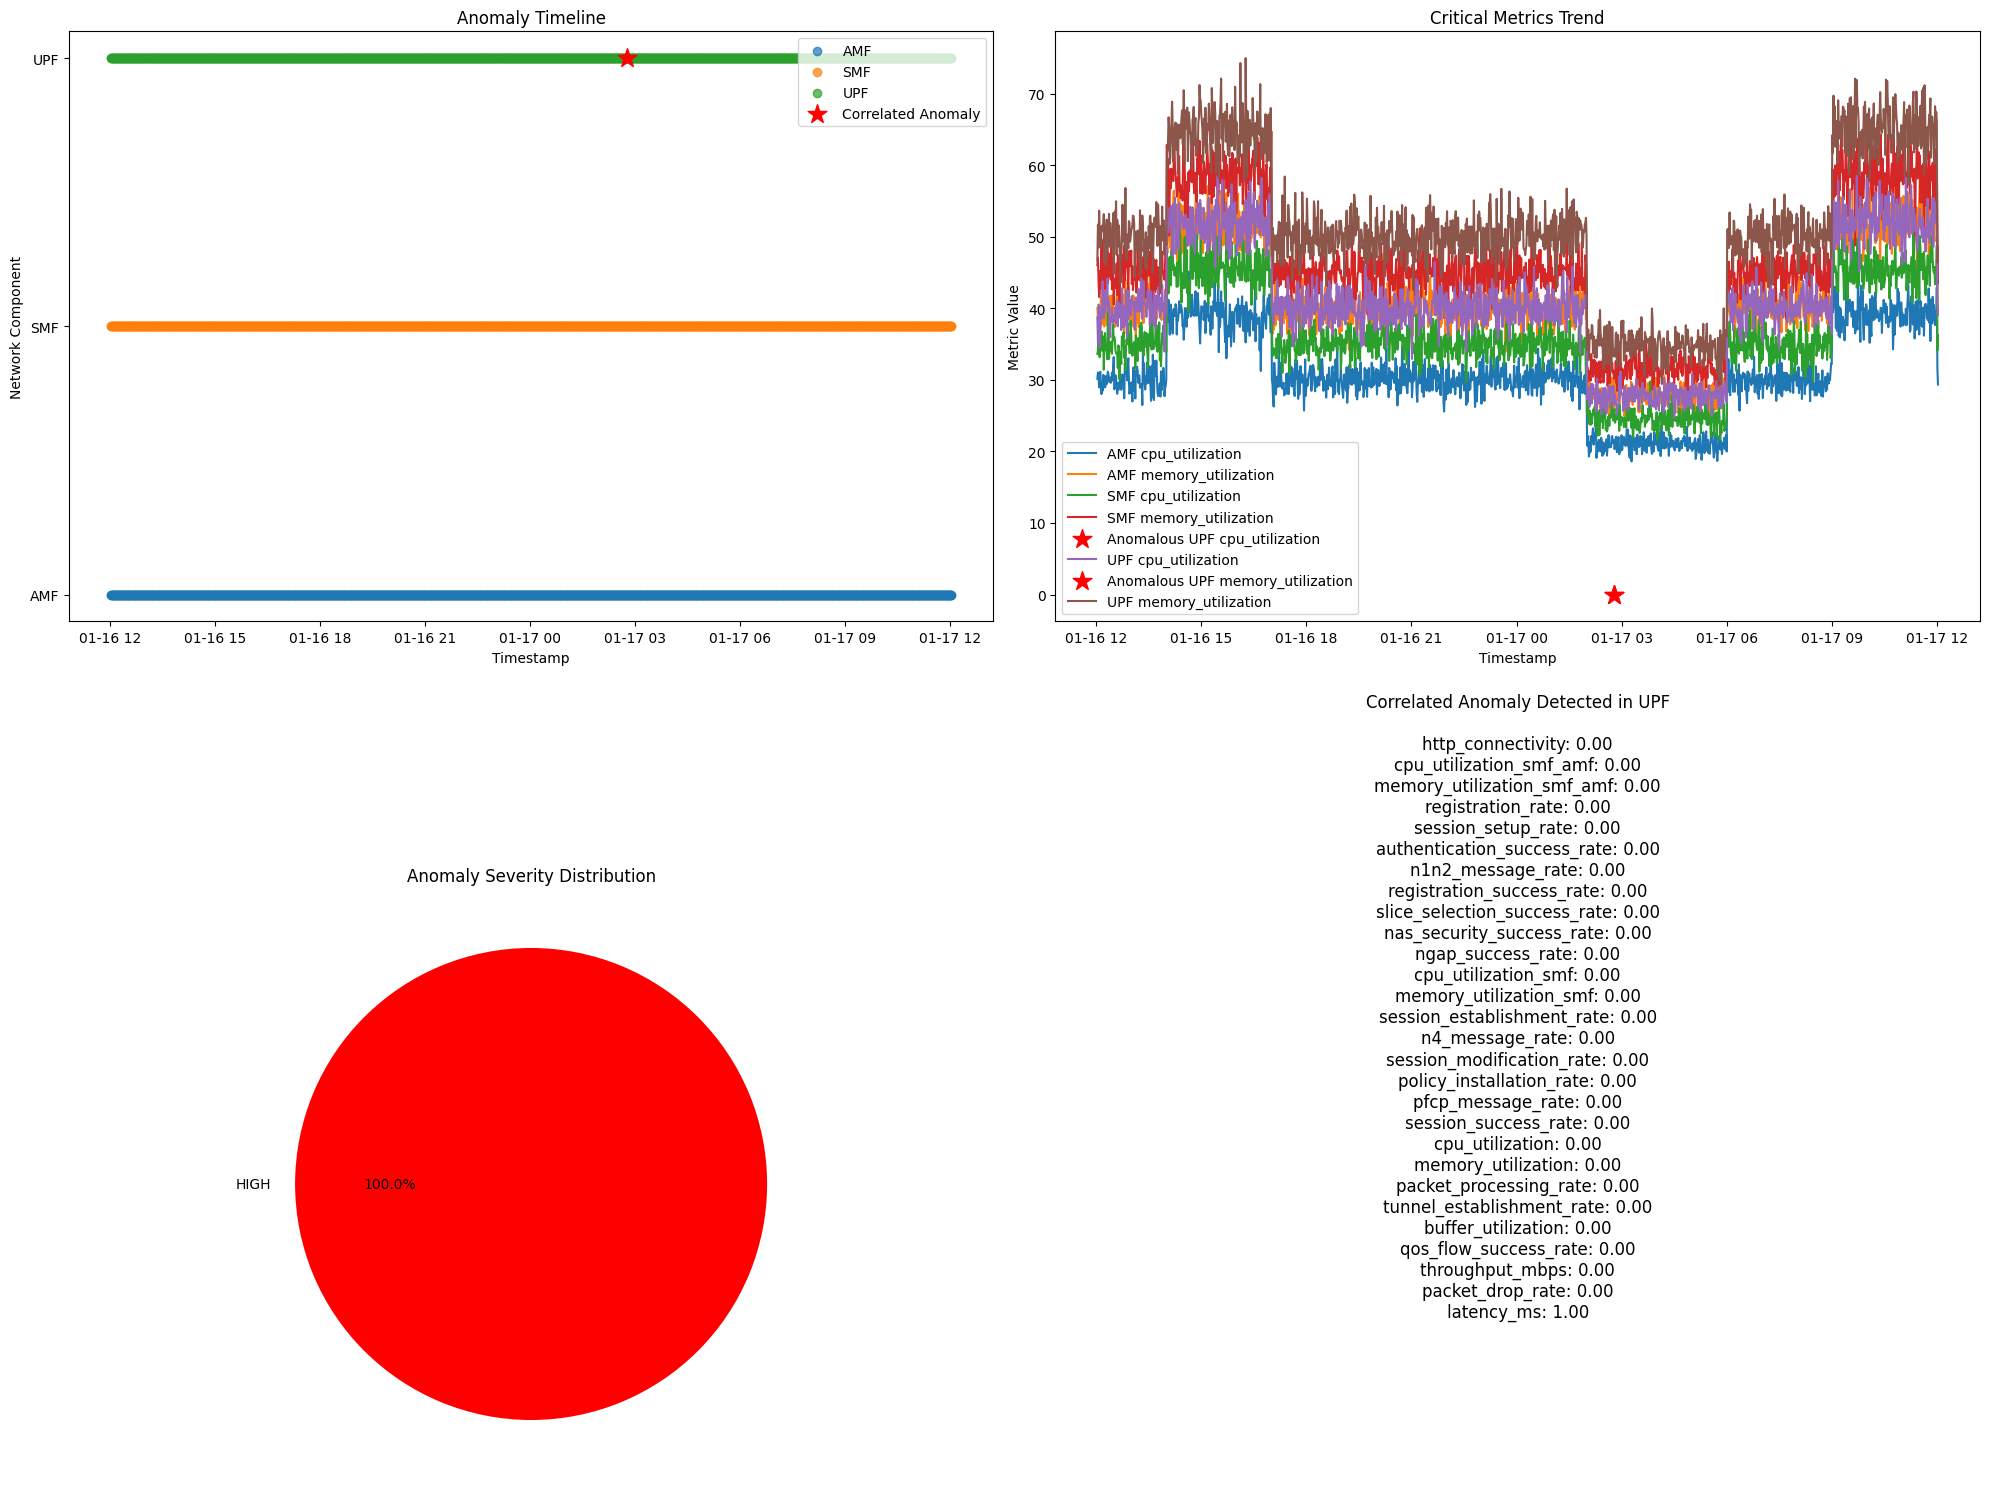


📈 Anomaly Visualizations Generated Successfully


In [20]:
# Load metrics
try:
    # Load metrics from predefined files
    metrics_data = load_metrics(METRIC_FILES)
    print(f"🔍 Metrics Loaded Successfully:")
    for component, df in metrics_data.items():
        print(f"  - {component.upper()}: {len(df)} records")
except Exception as e:
    print(f"❌ Error Loading Metrics: {e}")
    metrics_data = None

# Detect anomalies
if metrics_data:
    try:
        # Detect anomalies with default z-score threshold
        anomalies = detect_anomalies(metrics_data)
        
        # Log anomaly detection results
        print("\n📊 Anomaly Detection Results:")
        for component, df in anomalies.items():
            anomaly_count = df.drop(columns=['timestamp']).any(axis=1).sum()
            print(f"  - {component.upper()}: {anomaly_count} anomalies detected")
    except Exception as e:
        print(f"❌ Anomaly Detection Error: {e}")
        anomalies = None

# Correlate anomalies
if anomalies:
    try:
        # Correlate anomalies across network functions
        correlated_anomalies = correlate_anomalies(anomalies)
        
        print(f"\n🔗 Correlated Anomalies: {len(correlated_anomalies)} cross-component anomalies")
    except Exception as e:
        print(f"❌ Anomaly Correlation Error: {e}")
        correlated_anomalies = None

# Visualize anomalies
if metrics_data and anomalies and correlated_anomalies is not None:
    try:
        # Generate comprehensive visualizations
        visualize_anomalies(metrics_data, anomalies, correlated_anomalies)
        print("\n📈 Anomaly Visualizations Generated Successfully")
    except Exception as e:
        print(f"❌ Visualization Error: {e}")